## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [200]:
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [201]:
taxi = pd.read_csv('/Users/yakovlev/Downloads/taxi.csv', parse_dates=[0],index_col='datetime')
taxi.sort_index(inplace=True)
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [202]:
taxi_resampled = taxi.resample('1H').sum()
taxi_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

Посмотрим на стационарность данных

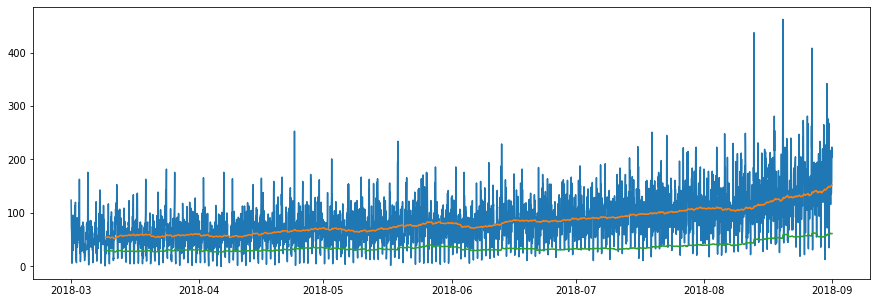

In [203]:
plt.figure(figsize=(15,5))
plt.plot(taxi_resampled)
plt.plot(taxi_resampled.rolling(200).mean())
plt.plot(taxi_resampled.rolling(200).std())
plt.show()

Как можем видеть, отклонение практически не меняется, следовательно данные стационарные. Это значит, что мы можем делать предсказания на основе машинного обучения

Посмотрим на тренд данных. Для просмотра сезонности маловат промежуток, но все равно изобразим график.

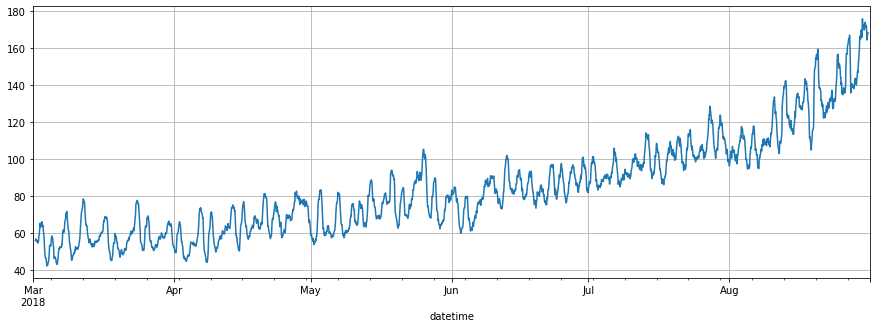

In [204]:
decomposed = seasonal_decompose(taxi_resampled)
decomposed.trend.plot(figsize=(15,5), grid=True)

Как можем видеть, к августу люди начинают пользоваться такси все больше и больше. Изобразим график сезонности.

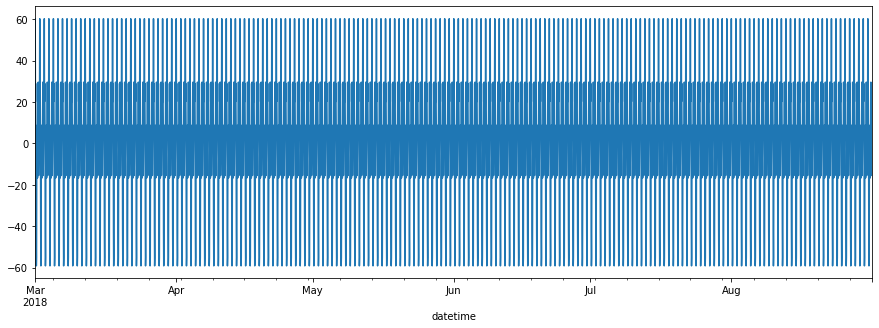

In [205]:
decomposed.seasonal.plot(figsize=(15,5), ax=plt.gca())

Получили ожидаемую сезонность, график цикличен и показывает, что в течение дня люди чаще пользуются такси днем, чем ночью. Если бы получили график за год, то вероятно увидели бы, что зимой такси становится более актуальным, чем в теплое время года.

## Вывод

Выяснили, что данные годятся для предсказывания количества заказов такси.

# 3. Обучение

Напишем класс SmartRegression, который будет добавлять новые фичи, предобрабатвыать данные, обучать нужную модель, выводить графики и вычислять RMSE.

In [206]:
class SmartRegressor():
        def __init__(self, data):
            self.data = data
            

        def make_features(self, rolling_size, lag, year=False,
                     month=False, day=False, dayofweek=False, hour=False):
            self.rolling_size = rolling_size
            self.lag = lag
            self.year = year
            self.month = month
            self.day = day
            self.dayofweek = dayofweek
            self.hour = hour
            
            if self.year:
                self.data['year'] = self.data.index.year
            if self.month:
                self.data['month'] = self.data.index.month
            if self.day:
                self.data['day'] = self.data.index.day
            if self.dayofweek:
                self.data['dayofweek'] = self.data.index.dayofweek
            if self.hour:
                self.data['hour'] = self.data.index.hour
            
            for i in range(1, self.lag + 1):
                self.data['lag {}'.format(i)] = self.data['num_orders'].shift(i)
            self.data['rolling_mean'] = self.data['num_orders'].shift().rolling(self.rolling_size).mean()
            
        def preprocessing_learning_predicting(self,  model):
            self.model = model
            
            self.data.dropna(inplace=True)
            
            train, test = train_test_split(self.data, test_size=0.1, shuffle=False, random_state=12345)
            
            self.feature_train = train.drop('num_orders', axis=1)
            self.target_train = train['num_orders']
            
            self.feature_test = test.drop('num_orders', axis=1)
            self.target_test = test['num_orders']
            
            
            self.model.fit(self.feature_train, self.target_train)
            
            self.predict_train = self.model.predict(self.feature_train)
            self.predict_test = self.model.predict(self.feature_test)
            return self.predict_train, self.target_train
        
        def plot_train_difference(self, rolling):
            self.rolling = rolling
            plt.figure(figsize=(20,5))
            plt.plot(self.target_train.rolling(self.rolling).mean())
            plt.plot(self.target_train.index, pd.Series(self.predict_train).rolling(self.rolling).mean())
            plt.grid()
            plt.legend(['Predict', 'Target'])
            plt.show()
        
        def plot_test_difference(self, rolling):
            self.rolling = rolling
            plt.figure(figsize=(20,5))
            plt.plot(self.target_test.rolling(self.rolling).mean())
            plt.plot(self.target_test.index, pd.Series(self.predict_test).rolling(self.rolling).mean())
            plt.grid()
            plt.legend(['Predict', 'Target'])
            plt.show()
        
        
        def rmse(self):
            return {'RMSE для тестовых данных': mean_squared_error(self.predict_test, self.target_test) ** 0.5,
                   'RMSE для обучающих данных': mean_squared_error(self.predict_train, self.target_train) ** 0.5}

Создадим объект model, в который передадим наши данные

In [207]:
model = SmartRegressor(data=taxi_resampled)

Добавим новые фичи и посмотрим на датасет

In [208]:
model.make_features(rolling_size=30, lag=15, dayofweek=True, hour=True)
taxi_resampled.head()

,num_orders,dayofweek,hour,lag 1,lag 2,lag 3,lag 4,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10,lag 11,lag 12,lag 13,lag 14,lag 15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Предобработаем датасет, обучим модель линейной регрессии,  а также предскажем данные на обучающей и тестовой выборках.

### LinearRegression

In [209]:
predict_train, predict_test = model.preprocessing_learning_predicting(model=LinearRegression())

Посмотрим, как распределились предсказания и точные ответы при предсказании на тренировочной выборке

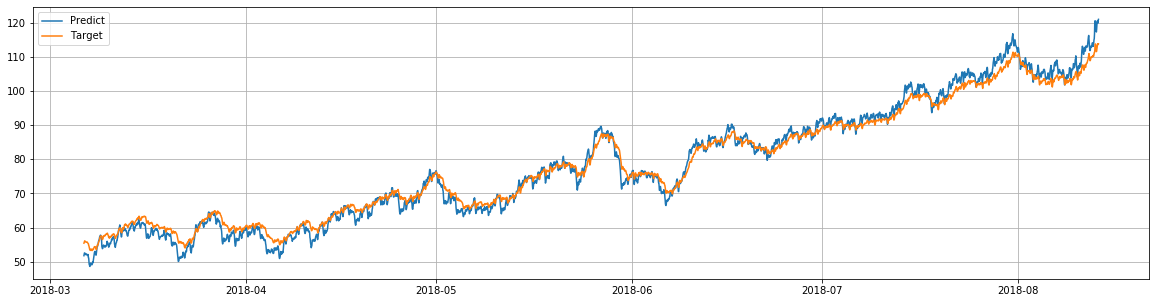

In [210]:
model.plot_train_difference(rolling=100)

Сделаем тоже самое, но уже на тестовых данных

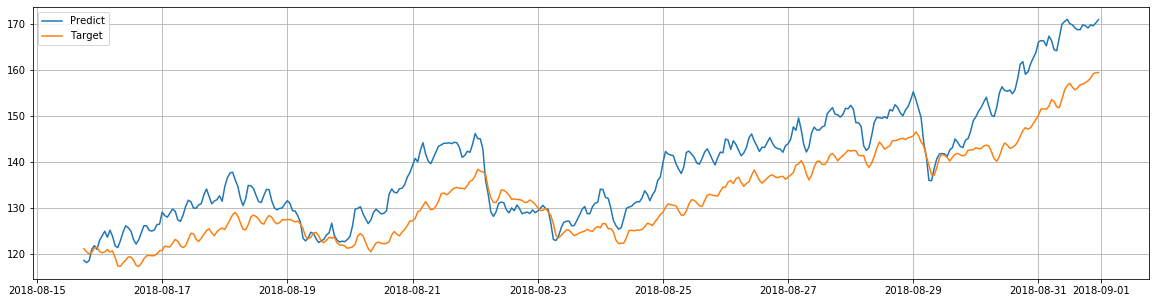

In [211]:
model.plot_test_difference(rolling=50)

Посмотрим значение метрики RMSE

In [212]:
model.rmse()

{'RMSE для тестовых данных': 50.399590116073085,
 'RMSE для обучающих данных': 30.06945040996498}

То же самое проделаем и для CatBoostRegressor, LGBMRegressor, XGBoostRegressor

### CatboostRegression

In [213]:
predict_train, predict_test = model.preprocessing_learning_predicting(model=CatBoostRegressor(verbose=False, early_stopping_rounds=5))

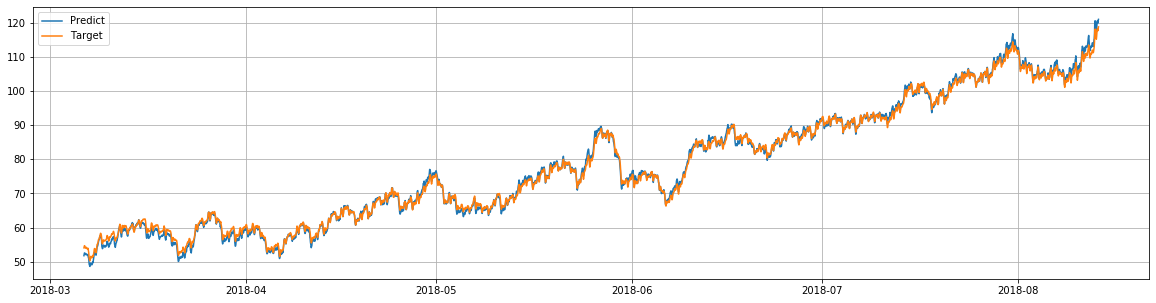

In [214]:
model.plot_train_difference(rolling=100)

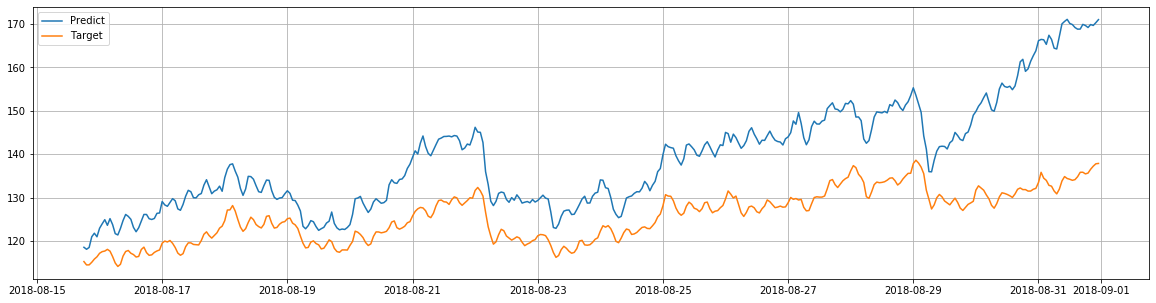

In [215]:
model.plot_test_difference(rolling=50)

In [216]:
model.rmse()

{'RMSE для тестовых данных': 41.93428242589891,
 'RMSE для обучающих данных': 12.042257583824973}

### LGBMRegression

In [217]:
predict_train, predict_test = model.preprocessing_learning_predicting(model=LGBMRegressor(learning_rate=0.1,
                                                                                          max_depth=7,
                                                                                          random_state=12345))

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


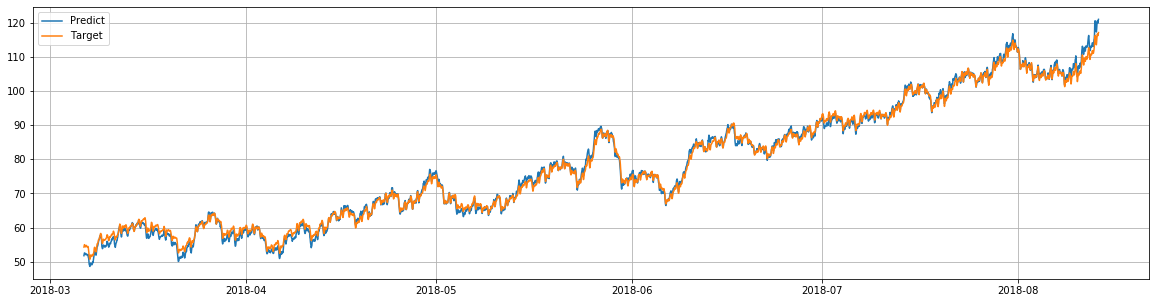

In [218]:
model.plot_train_difference(rolling=100)

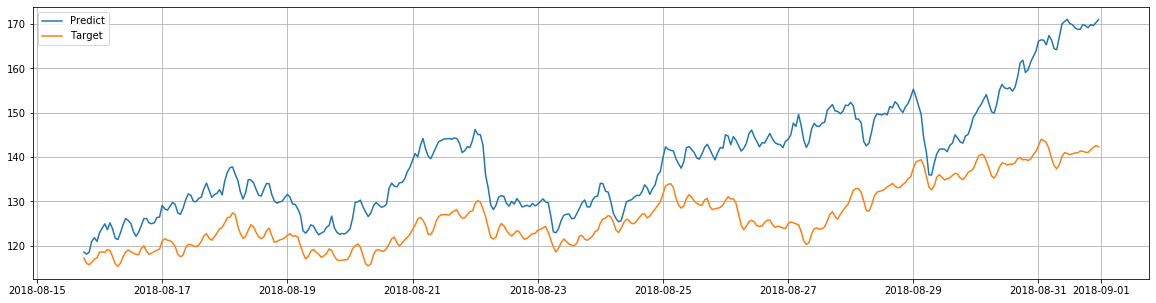

In [219]:
model.plot_test_difference(rolling=50)

In [220]:
model.rmse()

{'RMSE для тестовых данных': 41.833426026315486,
 'RMSE для обучающих данных': 14.376604997977875}

### XGBoostRegression

In [221]:
predict_train, predict_test = model.preprocessing_learning_predicting(model=XGBRegressor(learning_rate=0.2,
                                                                                         max_depth=4,
                                                                                         random_state=12345))

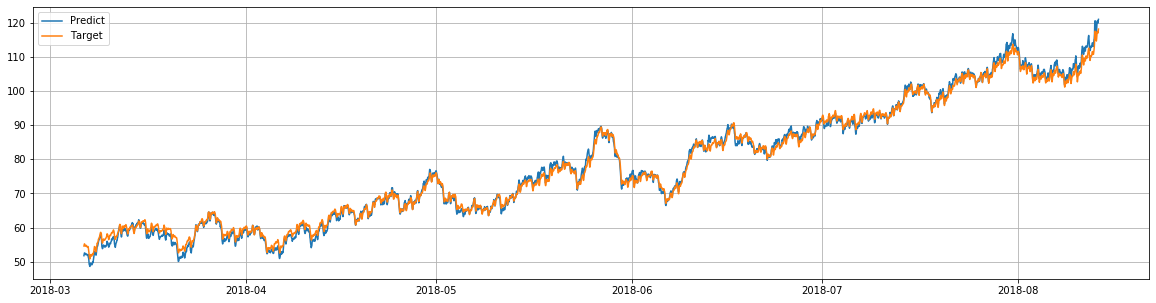

In [222]:
model.plot_train_difference(rolling=100)

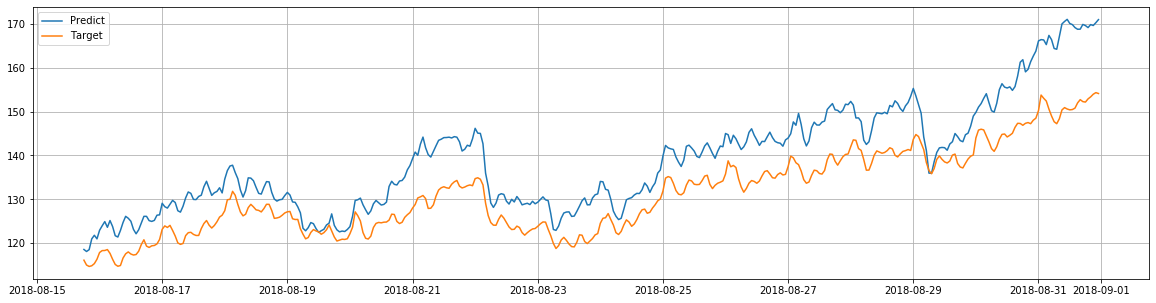

In [223]:
model.plot_test_difference(rolling=50)

In [224]:
model.rmse()

{'RMSE для тестовых данных': 42.0131460933856,
 'RMSE для обучающих данных': 15.053302172673678}

## Вывод

В результате получили, что градиентный бустниг показал результат лучше, чем линейная регрессия, а наилучшее значение RMSE получилось при использовании градиентного бустинга, находящегося в библиотеке LightGBM.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48